# What are the most important internal and external features in predicting rental prices?

In [1]:
# import library
import pandas as pd
import folium
import time
import re
import numpy as np

#spark session
from pyspark.sql import SparkSession


#feature engineering
from pyspark.ml.feature import StandardScaler
from pyspark.ml.feature import OneHotEncoder
from pyspark.ml.feature import StringIndexer
from pyspark.ml.feature import VectorAssembler
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import MulticlassClassificationEvaluator


#xgboost evaluation
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.metrics import accuracy_score

from sklearn.feature_selection import SelectFromModel
from xgboost import plot_importance
from matplotlib import pyplot

from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold
from xgboost import XGBRegressor

spark = (
    SparkSession.builder.appName("MAST30034 Project 2")
    .config("spark.sql.repl.eagerEval.enabled", True) 
    .config("spark.sql.parquet.cacheMetadata", "true")
    .config("spark.sql.session.timeZone", "Etc/UTC")
    .getOrCreate()
)

22/10/04 15:16:13 WARN Utils: Your hostname, QuzihandeMacBook-Pro.local resolves to a loopback address: 127.0.0.1; using 192.168.96.115 instead (on interface en0)
22/10/04 15:16:13 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


22/10/04 15:16:14 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


## Preprocessing

In [2]:
# read files
data = pd.read_csv('../data/curated/model-data/model-data.csv', index_col=0)
data = data.drop(columns = ['latitude', 'longitude'])

set condition with price, bedrooms and parking

In [3]:
data = data.loc[(data['price'] <= 1500) & (data['bedrooms'] <= 3)& (data['parking'] <= 5)]
data = data.loc[(data['price'] <= 2000) & (data['bedrooms'] <= 5)& (data['parking'] <= 5)]

In [4]:
data = spark.createDataFrame(data)

split future data for test set

In [5]:
TEST_SIZE = 0.2
train, test= data.randomSplit([1-TEST_SIZE, TEST_SIZE])

string indexer 

In [6]:
# string indexer 
string_indexer_columns = ['property_type']

# string indexer 
string_indexer_columns = ['property_type']
StringIndexer = [StringIndexer(inputCol= column, outputCol='{0}_index'.format(column)).setHandleInvalid("keep")\
                  for column in string_indexer_columns] 

one hot encoder preprocessing, put unseen value in new bucket

In [7]:
onehot_columns = ['postcode',
                  'bedrooms','bathrooms','parking',
                  'property_type_index']
                  
OneHotEncoders = [OneHotEncoder(inputCol= column, outputCol='{0}_vec'.format(column)).setHandleInvalid("keep")\
                  for column in onehot_columns] 

In [8]:
# other columns
other_columns = ['price',
                 'postcode_property_count','property-count', 'elector-count',
                 'public-service-duration','care-facility-duration', 'shopping-center-duration',
                 'train-station-duration', 'hospital-duration', 'CBD-duration',
                 'emergency-service-duration', 'crime-rate', 'income',
                 'pri-1-10', 'pri-11-50', 'pri-51-100','pri-101-150', 'pri-150+',
                 'sec-1-10', 'sec-11-50', 'sec-51-100','sec-101-150', 'sec-150+']

create feature vector

In [9]:
featuresCreator = VectorAssembler(
    inputCols=[OneHotEncoder.getOutputCol() for OneHotEncoder in OneHotEncoders] + other_columns,
    outputCol='features')

Pipeline

In [10]:
pipeline_model = (Pipeline(stages = StringIndexer + OneHotEncoders + [featuresCreator])).fit(train)

22/10/04 15:16:22 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


In [11]:
#create feature columns as MLP input
train = pipeline_model.transform(train)
test = pipeline_model.transform(test)

In [12]:
#feature scaling
Scalerizer=StandardScaler().setInputCol("features").setOutputCol("Scaled_features")
train_scaled = Scalerizer.fit(train).transform(train)
test_scaled = Scalerizer.fit(test).transform(test)

## XGBoost Model

In [13]:
columns_xgb = ['postcode', 'bedrooms','bathrooms','parking',
               'price', 'postcode_property_count', 'public-service-duration', 'care-facility-duration',
               'shopping-center-duration', 'train-station-duration', 'hospital-duration', 'CBD-duration',
               'emergency-service-duration', 'property-count', 'elector-count', 'crime-rate',
               'income', 'pri-1-10', 'pri-11-50', 'pri-51-100',
               'pri-101-150', 'pri-150+', 'sec-1-10', 'sec-11-50',
               'sec-51-100', 'sec-101-150', 'sec-150+', 'population-growth-rate',
               'property_type_index']

In [14]:
# set train and test data
train_xgb = train[columns_xgb]
test_xgb = test[columns_xgb]

In [15]:
# train
y_train = train_xgb.toPandas()['price']
x_train = train_xgb.toPandas().drop(columns = ['price'])

In [16]:
# test
y_test = test_xgb.toPandas()['price']
x_test = test_xgb.toPandas().drop(columns = ['price'])

In [17]:
# xtrain get dummy
x_train = pd.get_dummies(x_train, columns = ['bedrooms', 'bathrooms', 'parking','property_type_index'] ) 

In [18]:
# xtest get dummy
x_test = pd.get_dummies(x_test, columns = ['bedrooms', 'bathrooms', 'parking','property_type_index'] ) 

In [19]:
# Get missing columns in the training test
missing_cols = set(x_train.columns)-set(x_test.columns)

# Add a missing column in test set with default value equal to 0
for c in missing_cols:
    x_test[c] = 0
    
# Ensure the order of column in the test set is in the same order than in train set
x_test = x_test[x_train.columns]

## Grid search for the best parameters

In [20]:
parameters = {'nthread':[4], #when use hyperthread, xgboost may become slower
              'objective':['reg:squarederror'],
              'learning_rate': [0.02, 0.05],
              'max_depth': [4, 6, 10],
              'min_child_weight': [ 5, 7],
              'n_estimators': [500, 1000]}

model = XGBRegressor()

In [21]:
xgb_grid = GridSearchCV(estimator = model,
                        param_grid = parameters,
                        scoring='r2', 
                        verbose=1,
                        cv = 5)
                        
xgb_grid.fit(x_train, y_train)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    gamma=None, gpu_id=None, grow_policy=None,
                                    importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, max_bin=None,
                                    max_cat...
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None, n_estimators=100,
                                    n_jobs=None, num_parallel_tree=None,
                              

In [22]:
xgb_grid.best_estimator_

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.02, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=4, max_leaves=0, min_child_weight=5,
             missing=nan, monotone_constraints='()', n_estimators=500, n_jobs=4,
             nthread=4, num_parallel_tree=1, predictor='auto', random_state=0,
             reg_alpha=0, ...)

In [23]:
classifier = XGBRegressor(learning_rate=0.02,
                     max_bin=256,
                     max_cat_to_onehot=4,
                     max_delta_step=0,
                     max_depth=4, 
                     max_leaves=0, 
                     min_child_weight=5,
                     n_estimators=500, 
                     n_jobs=4,
                     nthread=4, 
                     num_parallel_tree=1)
classifier .fit(x_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.02, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=4, max_leaves=0, min_child_weight=5,
             missing=nan, monotone_constraints='()', n_estimators=500, n_jobs=4,
             nthread=4, num_parallel_tree=1, predictor='auto', random_state=0,
             reg_alpha=0, ...)

## Model Summary - RMSE and r2 score


In [24]:
predictions = classifier.predict(x_test)
rmse = np.sqrt(mean_squared_error(y_test, predictions))
print("RMSE: %f" % (rmse))

r2 = np.sqrt(r2_score(y_test, predictions))
print("R_Squared Score : %f" % (r2))

RMSE: 96.789099
R_Squared Score : 0.829463


## Top 15 importance features based on gain
**with one-hot encoding on categorial columns: 'bedrooms', 'bathrooms', 'parking', 'property_type_index'**

,feature,importance
27,bathrooms_1,0.244870
7,CBD-duration,0.092284
26,bedrooms_3,0.089464
24,bedrooms_1,0.080533
11,crime-rate,0.073585
12,income,0.059644
25,bedrooms_2,0.033566
33,parking_2,0.033368
37,property_type_index_0.0,0.021654
29,bathrooms_3,0.019728


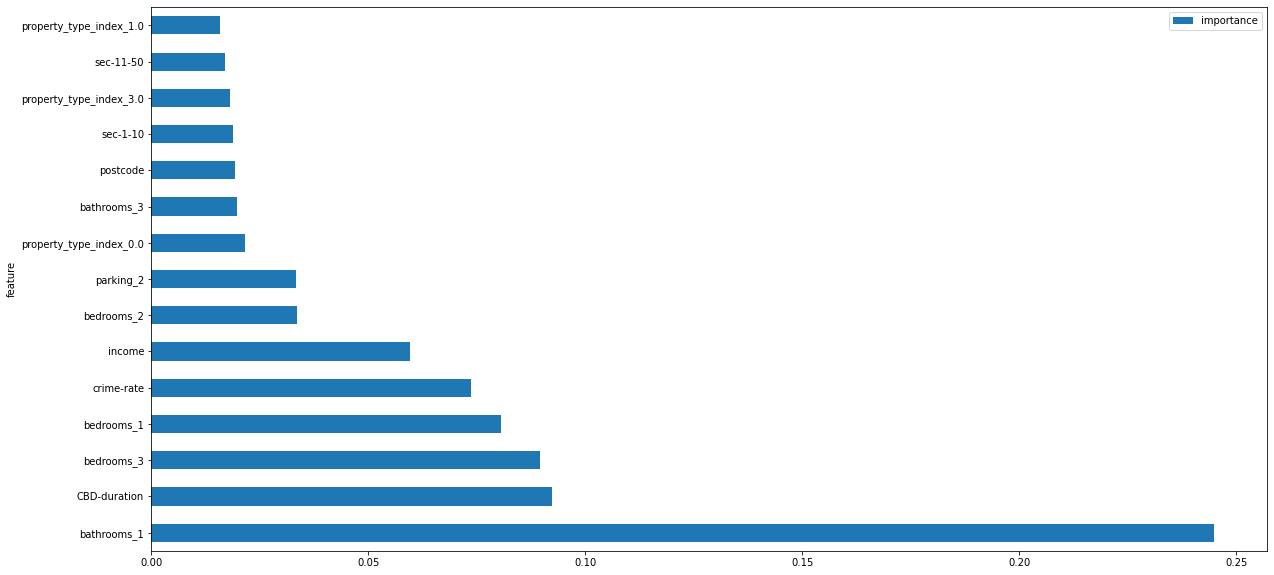

In [25]:
# create dict to use later
myfeatures = x_train.columns
dict_features = dict(enumerate(myfeatures))
list_imortance = list(classifier.feature_importances_)

# create dafaframe to store feature importance
features_df = pd.DataFrame.from_dict(dict_features, orient='index', columns = ['feature'])
features_df['importance'] = list_imortance
features_df = features_df.sort_values(by = ['importance'], ascending = False)

# ordered. by gain
features_df.head(15).plot(kind='barh', x='feature',figsize =(20,10))
features_df.head(15)

## Result

Summary:

    - The most important internal features are bathrooms, bedrooms and parking

    - The most important external features are the duration to CBD, crime rate and income